# Прогнозирование многомерных рядов на LSTM

## библиотеки

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и предварительная обработка данных

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Prediction models/temp+co2.xlsx') 
df.drop(columns=['Unnamed: 0'],inplace=True)
df.index = df['date']
df.drop(columns=['date'],inplace=True)
df.sort_index(inplace=True)

In [4]:
df

,Press,T_50m,T_30m,Rh_50m,Rs_downwell,Rs_upwell,Rl_downwell,S1CO2,S2CO2,S3CO2,S4CO2,S5CO2,S6CO2,S7CO2,S8CO2
date,,,,,,,,,,,,,,,
2012-01-01,99.012500,24.081250,24.094012,85.796459,182.854168,20.580625,410.645717,404.632292,414.877501,427.788958,434.414170,443.187915,447.444583,451.643542,455.474374
2012-01-02,98.945833,24.771042,24.946304,81.206666,251.512708,28.952083,401.059894,406.827291,415.108961,421.729790,427.613333,437.722292,444.683331,450.714168,457.092290
2012-01-03,98.935416,24.798542,24.787784,76.589166,238.917084,28.098333,391.427979,400.272919,411.619375,420.682084,427.016667,432.769791,436.861247,441.994166,446.911876
2012-01-04,99.020833,24.505208,24.198398,79.331042,197.701457,23.416041,388.051685,402.337917,416.241459,427.289378,435.596873,442.819374,446.417084,450.013128,453.528752
2012-01-05,99.031250,24.920208,24.666129,75.010208,236.973541,28.422084,386.634165,400.027292,410.595837,426.915211,434.374793,440.301252,444.967709,449.462709,453.839376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,32.790987,-5.161875,26.198750,38.103542,118.015418,-9.417917,292.822296,429.934167,438.973749,450.595415,459.626670,472.245206,480.333333,496.237291,544.110416
2017-12-28,98.707142,25.257083,26.070000,81.465416,214.397291,23.717083,410.724892,424.039375,430.170000,440.580624,447.460000,457.913752,461.509375,471.033751,495.118749
2017-12-29,98.730358,25.618125,26.102500,79.564583,227.716875,24.748333,410.738056,417.846667,425.361039,437.242710,448.183124,460.695630,465.091458,475.359166,498.605836


In [5]:
k = 61
data = df[df.index < (datetime.strptime("2015-07-01", "%Y-%m-%d") + timedelta(days=k))]
data = data[['T_30m','S1CO2','S2CO2']]

In [6]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Создание наборов данных для обучения и тестирования
train_size = 1277 - 3  #int(len(scaled_data) * 0.8) 1277 дней между 01.01.2012 и 01.07.2015
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Преобразование данных для подачи в LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Создание и обучение модели LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, X_train.shape[2])))
model.add(Dense(X_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)

# Прогнозирование и оценка модели
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Обратное преобразование нормализованных данных в исходные значения
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test)

# Вычисление ошибки прогнозирования
train_score = np.sqrt(mean_squared_error(Y_train, train_predict))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(Y_test, test_predict))
print(f'Test Score: {test_score:.2f} RMSE')


Epoch 1/20
1270/1270 - 7s - loss: 0.0242 - 7s/epoch - 6ms/step
Epoch 2/20
1270/1270 - 2s - loss: 0.0129 - 2s/epoch - 2ms/step
Epoch 3/20
1270/1270 - 2s - loss: 0.0125 - 2s/epoch - 2ms/step
Epoch 4/20
1270/1270 - 2s - loss: 0.0121 - 2s/epoch - 2ms/step
Epoch 5/20
1270/1270 - 3s - loss: 0.0119 - 3s/epoch - 2ms/step
Epoch 6/20
1270/1270 - 3s - loss: 0.0118 - 3s/epoch - 2ms/step
Epoch 7/20
1270/1270 - 2s - loss: 0.0117 - 2s/epoch - 2ms/step
Epoch 8/20
1270/1270 - 2s - loss: 0.0114 - 2s/epoch - 2ms/step
Epoch 9/20
1270/1270 - 2s - loss: 0.0115 - 2s/epoch - 2ms/step
Epoch 10/20
1270/1270 - 3s - loss: 0.0114 - 3s/epoch - 2ms/step
Epoch 11/20
1270/1270 - 3s - loss: 0.0114 - 3s/epoch - 3ms/step
Epoch 12/20
1270/1270 - 2s - loss: 0.0113 - 2s/epoch - 2ms/step
Epoch 13/20
1270/1270 - 2s - loss: 0.0113 - 2s/epoch - 2ms/step
Epoch 14/20
1270/1270 - 2s - loss: 0.0113 - 2s/epoch - 2ms/step
Epoch 15/20
1270/1270 - 2s - loss: 0.0113 - 2s/epoch - 2ms/step
Epoch 16/20
1270/1270 - 3s - loss: 0.0113 - 3s/ep

In [7]:
mse_temp = mean_squared_error(Y_test[:,0], test_predict[:,0])
mse_conc50 = mean_squared_error(Y_test[:,1], test_predict[:,1])
mse_conc30 = mean_squared_error(Y_test[:,2], test_predict[:,2])
print(f'len: {len(Y_test[:,0])}, temp: {mse_temp}, conc50: {mse_conc50}, conc30: {mse_conc30}')

len: 60, temp: 0.9418820095297519, conc50: 50.575197825355524, conc30: 73.57100954349356


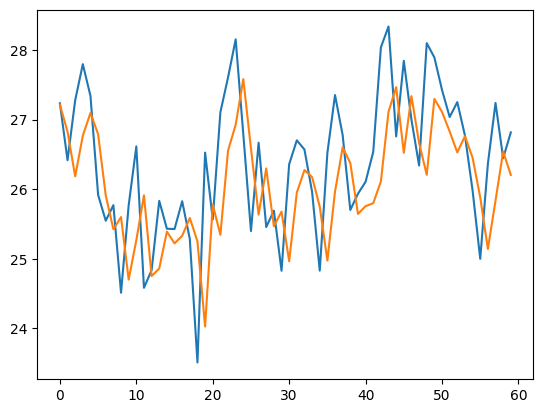

In [8]:
plt.plot(Y_test[:,0])
plt.plot(test_predict[:,0])

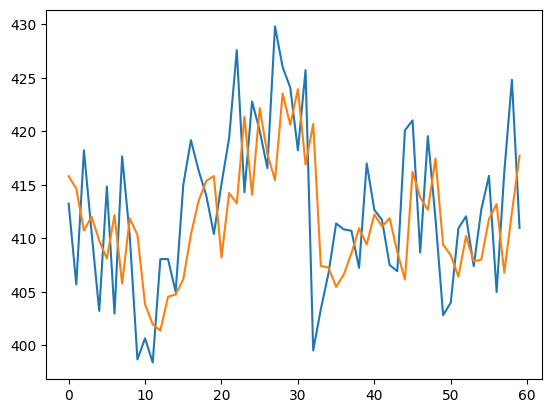

In [9]:
plt.plot(Y_test[:,1])
plt.plot(test_predict[:,1])

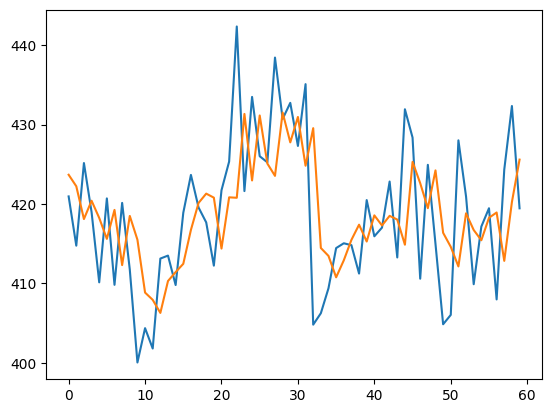

In [10]:
plt.plot(Y_test[:,2])
plt.plot(test_predict[:,2])

In [11]:
Y_test[:,0]

array([27.23333335, 26.41541656, 27.27562492, 27.79562502, 27.33916648,
       25.9177084 , 25.54604165, 25.76979154, 24.51145827, 25.76854175,
       26.61395823, 24.58208348, 24.83541665, 25.83166669, 25.43062519,
       25.42666665, 25.82583331, 25.28312506, 23.50937506, 26.52458333,
       25.56458354, 27.10499981, 27.60437506, 28.15145817, 26.78624996,
       25.39770833, 26.66708344, 25.45437512, 25.69020823, 24.82729169,
       26.35791671, 26.70125006, 26.56875023, 25.96041644, 24.82895815,
       26.52062485, 27.35125004, 26.77583333, 25.70062465, 25.93354173,
       26.10562498, 26.53500002, 28.03645835, 28.3366666 , 26.75666671,
       27.84270835, 26.99749987, 26.33916646, 28.09770831, 27.89145829,
       27.42437508, 27.03583335, 27.25000002, 26.76958337, 25.98083329,
       24.99854171, 26.3629166 , 27.23812502, 26.44333333, 26.81520815])

In [12]:
test_predict[:,0]

array([27.214016, 26.82472 , 26.183834, 26.767435, 27.093872, 26.788464,
       25.908813, 25.423544, 25.598269, 24.700546, 25.265852, 25.91076 ,
       24.750702, 24.859602, 25.389215, 25.220158, 25.329527, 25.585396,
       25.248363, 24.025019, 25.778316, 25.343943, 26.551891, 26.925701,
       27.580435, 26.585041, 25.633017, 26.296383, 25.466032, 25.676544,
       24.963575, 25.949766, 26.27373 , 26.173058, 25.749   , 24.97404 ,
       25.964523, 26.599672, 26.374805, 25.64377 , 25.755724, 25.79786 ,
       26.109367, 27.111362, 27.464489, 26.521889, 27.335321, 26.663519,
       26.205631, 27.295898, 27.108734, 26.82806 , 26.52714 , 26.76091 ,
       26.451374, 25.881784, 25.140335, 25.834625, 26.541006, 26.203304],
      dtype=float32)

In [13]:
data[data.index >= datetime.strptime("2015-07-01", "%Y-%m-%d")]

,T_30m,S1CO2,S2CO2
date,,,
2015-07-01,27.233333,413.247291,420.955625
2015-07-02,26.415417,405.683333,414.752291
2015-07-03,27.275625,418.218959,425.158542
2015-07-04,27.795625,410.562084,418.986667
2015-07-05,27.339166,403.216668,410.130835
...,...,...,...
2015-08-26,26.362917,404.978958,407.978750
2015-08-27,27.238125,416.160002,424.340415
2015-08-28,26.443333,424.807081,432.343959


# GRU learning

In [13]:
def mse_table(Y_test,test_predict):
    mse = pd.DataFrame(columns =['period', 'T30', 'CO2_50', 'CO2_30']) 
    for  t in range(1,len(Y_test[:,0])+1 ):
      mse_temp = mean_squared_error(Y_test[:t,0], test_predict[:t,0])
      mse_conc50 = mean_squared_error(Y_test[:t,1], test_predict[:t,1])
      mse_conc30 = mean_squared_error(Y_test[:t,2], test_predict[:t,2])
      #print(f'len: {len(Y_test[:t,0])}, temp: {mse_temp}, conc50: {mse_conc50}, conc30: {mse_conc30}')
      row2 = {'period': len(Y_test[:t,0]), 'T30' : mse_temp, 'CO2_50' : mse_conc50, 'CO2_30' : mse_conc30}
      row2df = pd.DataFrame.from_records([row2])
      mse = pd.concat([mse, row2df], ignore_index=True, axis=0) 
    mse_lstm = mse.copy()
    mse_lstm.rename(columns={"T30": f'T30_m_{model}_n_{neurons}_e_{count_epochs}', 
                            "CO2_50": f'CO2_50_m_{model}_n_{neurons}_e_{count_epochs}',
                            "CO2_30": f'CO2_30_m_{model}_n_{neurons}_e_{count_epochs}'}, inplace = True)
    mse_lstm.to_excel(f'/content/drive/MyDrive/Prediction models/new GRU/mse {model} series_{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.xlsx')

In [14]:
def data_table(Y_test,test_predict):
    mse = pd.DataFrame(columns =['period', 'data', 'T30_r', 'CO2_50_r', 'CO2_30_r', 'T30', 'CO2_50', 'CO2_30']) 
    for  t in range(len(Y_test[:,0])):
      df_temp_r = Y_test[t,0]
      df_conc50_r = Y_test[t,1]
      df_conc30_r = Y_test[t,2]
      df_temp = test_predict[t,0]
      df_conc50 = test_predict[t,1]
      df_conc30 = test_predict[t,2]

      row2 = {'period': len(Y_test[:t,0])+1, 
              'data' : datetime.strptime("2015-07-01", "%Y-%m-%d") + timedelta(days=len(Y_test[:t,0])),
              'T30_r' : df_temp_r, 'CO2_50_r' : df_conc50_r, 'CO2_30_r' : df_conc30_r,
              'T30' : df_temp, 'CO2_50' : df_conc50, 'CO2_30' : df_conc30}
      row2df = pd.DataFrame.from_records([row2])
      mse = pd.concat([mse, row2df], ignore_index=True, axis=0) 
    mse_lstm = mse.copy()
    mse_lstm.rename(columns={"T30": f'T30_m_{model}_n_{neurons}_e_{count_epochs}', 
                            "CO2_50": f'CO2_50_m_{model}_n_{neurons}_e_{count_epochs}',
                            "CO2_30": f'CO2_30_m_{model}_n_{neurons}_e_{count_epochs}'}, inplace = True)
    mse_lstm.to_excel(f'/content/drive/MyDrive/Prediction models/new GRU/data table {model} series_{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.xlsx')

In [15]:
def T30_graf(Y_test,test_predict):
    fig, ax = plt.subplots(figsize=(12, 6)) #figsize=(12, 6)
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.plot(Y_test[:,0])
    plt.plot(test_predict[:,0])
    plt.legend(['Исходные данные', model])
    plt.xlabel('Горизонт прогнозирования, сутки',fontsize=12)
    plt.ylabel('Температура, $^{o}$C', fontsize=12)
    plt.savefig(f'/content/drive/MyDrive/Prediction models/new GRU/T_30 m_{model} series_{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.jpg',
                dpi=300) 
    plt.savefig(f'/content/drive/MyDrive/Prediction models/new GRU/T_30 m_{model} series_{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.png',
                dpi=300) 
    plt.close()

In [16]:
def CO2_50_graf(Y_test,test_predict):
    fig, ax = plt.subplots(figsize=(12, 6)) #figsize=(12, 6)
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.plot(Y_test[:,1])
    plt.plot(test_predict[:,1])
    plt.legend(['Исходные данные', model])
    plt.xlabel('Горизонт прогнозирования, сутки',fontsize=12)
    plt.ylabel('Концентрация $CO_{2}$, млн$^{-1}$', fontsize=12)
    plt.savefig(f'/content/drive/MyDrive/Prediction models/new GRU/CO2_50 m_{model} series{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.jpg', 
                dpi=300) 
    plt.savefig(f'/content/drive/MyDrive/Prediction models/new GRU/CO2_50 m_{model} series{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.png', 
                dpi=300) 
    plt.close()

In [17]:
def CO2_30_graf(Y_test,test_predict):
    fig, ax = plt.subplots(figsize=(12, 6)) #figsize=(12, 6)
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.plot(Y_test[:,2])
    plt.plot(test_predict[:,2])
    plt.legend(['Исходные данные', model])
    plt.xlabel('Горизонт прогнозирования, сутки',fontsize=12)
    plt.ylabel('Концентрация $CO_{2}$, млн$^{-1}$', fontsize=12)
    plt.savefig(f'/content/drive/MyDrive/Prediction models/new GRU/CO2_30 m_{model} series{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.jpg', 
                dpi=300) 
    plt.savefig(f'/content/drive/MyDrive/Prediction models/new GRU/CO2_30 m_{model} series{3}_neurons_{neurons}_epochs_{count_epochs}_date_{datetime.now()}.png',
                dpi=300) 
    plt.close()

In [18]:
model = 'GRU'
def gru_learning(neurons,count_epochs):
    
    g = 59
    #for g in range(60):
    k = 61 - 59 + g
    print (f'\n Прогноз на {g+1} день \n')
    data = df[df.index < (datetime.strptime("2015-07-01", "%Y-%m-%d") + timedelta(days=k))]
    data = data[['T_30m','S1CO2','S2CO2']]

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Создание наборов данных для обучения и тестирования
    train_size = 1277 - 3  #int(len(scaled_data) * 0.8) 1277 дней между 01.01.2012 и 01.07.2015
    test_size = len(scaled_data) - train_size
    train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

    # Преобразование данных для подачи в LSTM
    def create_dataset(dataset, look_back=1):
      X, Y = [], []
      for i in range(len(dataset)-look_back-1):
          a = dataset[i:(i+look_back), :]
          X.append(a)
          Y.append(dataset[i + look_back, :])
      return np.array(X), np.array(Y)

    look_back = 3
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Создание и обучение модели LSTM
    model = Sequential()
    model.add(GRU(neurons, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(X_train.shape[2]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=count_epochs, batch_size=1, verbose=1)

    # Прогнозирование и оценка модели
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Обратное преобразование нормализованных данных в исходные значения
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform(Y_train)
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform(Y_test)

    # Вычисление ошибки прогнозирования
    train_score = np.sqrt(mean_squared_error(Y_train, train_predict))
    print(f'Train Score: {train_score:.2f} RMSE')
    test_score = np.sqrt(mean_squared_error(Y_test, test_predict))
    print(f'Test Score: {test_score:.2f} RMSE')

    mse_table(Y_test,test_predict)
    data_table(Y_test,test_predict)
    T30_graf(Y_test,test_predict)
    CO2_50_graf(Y_test,test_predict)
    CO2_30_graf(Y_test,test_predict)

In [19]:
#Constants:
neurons_all = [50, 100, 200]
count_epochs_all = [20, 50, 100, 200]
t1 = datetime.now()
print(f'Начало работы программы: {t1} \n')
for neurons in neurons_all:
  for count_epochs in count_epochs_all:
    t3 = datetime.now()
    print(f'Начало обучения GRU n = {neurons}, e = {count_epochs}: {t3}')
    gru_learning(neurons,count_epochs)
    t4 = datetime.now()
    print(f'Конец обучения GRU n = {neurons}, e = {count_epochs}: {t4} \n Время обучения: {t4-t3} \n')

t2 = datetime.now()
print(f'Конец работы программы: {t2} \n Время работы программы: {t2-t1}')

Начало работы программы: 2023-04-28 20:08:29.517742 

Начало обучения GRU n = 50, e = 20: 2023-04-28 20:08:29.519112

 Прогноз на 60 день 

Epoch 1/20
1270/1270 [==============================] - 6s 3ms/step - loss: 0.0164
Epoch 2/20
1270/1270 [==============================] - 3s 3ms/step - loss: 0.0123
Epoch 3/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0122
Epoch 4/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0119
Epoch 5/20
1270/1270 [==============================] - 4s 3ms/step - loss: 0.0117
Epoch 6/20
1270/1270 [==============================] - 4s 3ms/step - loss: 0.0117
Epoch 7/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0117
Epoch 8/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0116
Epoch 9/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0116
Epoch 10/20
1270/1270 [==============================] - 4s 3ms/step - loss: 0.0116
Epoch 11/20
1270/1270 [======

In [20]:
1+1

2

In [ ]:
#Constants:
neurons_all = [50]
count_epochs_all = [20, 50, 100]
t1 = datetime.now()
print(f'Начало работы программы: {t1} \n')
for neurons in neurons_all:
  for count_epochs in count_epochs_all:
    t3 = datetime.now()
    print(f'Начало обучения GRU n = {neurons}, e = {count_epochs}: {t3}')
    gru_learning(neurons,count_epochs)
    t4 = datetime.now()
    print(f'Конец обучения GRU n = {neurons}, e = {count_epochs}: {t4} \n Время обучения: {t4-t3} \n')

t2 = datetime.now()
print(f'Конец работы программы: {t2} \n Время работы программы: {t2-t1}')

Начало работы программы: 2023-04-10 08:18:35.896891 

Начало обучения GRU n = 50, e = 20: 2023-04-10 08:18:35.898300

 Прогноз на 60 день 

Epoch 1/20
1270/1270 [==============================] - 5s 3ms/step - loss: 0.0156
Epoch 2/20
1270/1270 [==============================] - 4s 3ms/step - loss: 0.0122
Epoch 3/20
1270/1270 [==============================] - 3s 3ms/step - loss: 0.0120
Epoch 4/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0120
Epoch 5/20
1270/1270 [==============================] - 3s 3ms/step - loss: 0.0117
Epoch 6/20
1270/1270 [==============================] - 4s 3ms/step - loss: 0.0116
Epoch 7/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0115
Epoch 8/20
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0114
Epoch 9/20
1270/1270 [==============================] - 3s 3ms/step - loss: 0.0114
Epoch 10/20
1270/1270 [==============================] - 4s 3ms/step - loss: 0.0114
Epoch 11/20
1270/1270 [======

# GRU Learning [OLD]

In [ ]:
mse = pd.DataFrame(columns =['period', 'T30', 'CO2_50', 'CO2_30']) 
g = 59
#for g in range(60):
k = 61 - 59 + g
print (f'\n Прогноз на {g+1} день \n')
data = df[df.index < (datetime.strptime("2015-07-01", "%Y-%m-%d") + timedelta(days=k))]
data = data[['T_30m','S1CO2','S2CO2']]
#data = data[['T_30m','S2CO2']]

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Создание наборов данных для обучения и тестирования
train_size = 1277 - 3  #int(len(scaled_data) * 0.8) 1277 дней между 01.01.2012 и 01.07.2015
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Преобразование данных для подачи в LSTM
def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), :]
      X.append(a)
      Y.append(dataset[i + look_back, :])
  return np.array(X), np.array(Y)

look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Создание и обучение модели LSTM
model = Sequential()
model.add(GRU(200, input_shape=(look_back, X_train.shape[2])))
model.add(Dense(X_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=1, verbose=2)

# Прогнозирование и оценка модели
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Обратное преобразование нормализованных данных в исходные значения
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test)

# Вычисление ошибки прогнозирования
train_score = np.sqrt(mean_squared_error(Y_train, train_predict))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(Y_test, test_predict))
print(f'Test Score: {test_score:.2f} RMSE')

mse_temp = mean_squared_error(Y_test[:,0], test_predict[:,0])
mse_conc30 = mean_squared_error(Y_test[:,1], test_predict[:,1])
mse_conc30 = mean_squared_error(Y_test[:,2], test_predict[:,2])
print(f'len: {len(Y_test[:,0])}, temp: {mse_temp}, conc50: {mse_conc50}, conc30: {mse_conc30}')
mse = mse.append({'period': len(Y_test[:,0]), 'T30' : mse_temp, 'CO2_50' : mse_conc50, 'CO2_30' : mse_conc30}, ignore_index=True)


 Прогноз на 60 день 

Epoch 1/200
1270/1270 - 7s - loss: 0.0146 - 7s/epoch - 5ms/step
Epoch 2/200
1270/1270 - 6s - loss: 0.0124 - 6s/epoch - 5ms/step
Epoch 3/200
1270/1270 - 5s - loss: 0.0120 - 5s/epoch - 4ms/step
Epoch 4/200
1270/1270 - 6s - loss: 0.0121 - 6s/epoch - 5ms/step
Epoch 5/200
1270/1270 - 5s - loss: 0.0121 - 5s/epoch - 4ms/step
Epoch 6/200
1270/1270 - 5s - loss: 0.0118 - 5s/epoch - 4ms/step
Epoch 7/200
1270/1270 - 8s - loss: 0.0118 - 8s/epoch - 6ms/step
Epoch 8/200
1270/1270 - 5s - loss: 0.0115 - 5s/epoch - 4ms/step
Epoch 9/200
1270/1270 - 6s - loss: 0.0116 - 6s/epoch - 5ms/step
Epoch 10/200
1270/1270 - 5s - loss: 0.0115 - 5s/epoch - 4ms/step
Epoch 11/200
1270/1270 - 5s - loss: 0.0116 - 5s/epoch - 4ms/step
Epoch 12/200
1270/1270 - 6s - loss: 0.0113 - 6s/epoch - 4ms/step
Epoch 13/200
1270/1270 - 5s - loss: 0.0114 - 5s/epoch - 4ms/step
Epoch 14/200
1270/1270 - 7s - loss: 0.0113 - 7s/epoch - 5ms/step
Epoch 15/200
1270/1270 - 5s - loss: 0.0114 - 5s/epoch - 4ms/step
Epoch 16/20

<ipython-input-32-38f0dfcf8ba9>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append({'period': len(Y_test[:,0]), 'T30' : mse_temp, 'CO2_50' : mse_conc50, 'CO2_30' : mse_conc30}, ignore_index=True)


In [ ]:
mse = pd.DataFrame(columns =['period', 'T30', 'CO2_50', 'CO2_30']) 
for  t in range(1,len(Y_test[:,0])+1 ):
  mse_temp = mean_squared_error(Y_test[:t,0], test_predict[:t,0])
  mse_conc50 = mean_squared_error(Y_test[:t,1], test_predict[:t,1])
  mse_conc30 = mean_squared_error(Y_test[:t,2], test_predict[:t,2])
  #print(f'len: {len(Y_test[:t,0])}, temp: {mse_temp}, conc50: {mse_conc50}, conc30: {mse_conc30}')
  mse = mse.append({'period': len(Y_test[:t,0]), 'T30' : mse_temp, 'CO2_50' : mse_conc50, 'CO2_30' : mse_conc30}, ignore_index=True)

<ipython-input-33-99c2bbb8dfce>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append({'period': len(Y_test[:t,0]), 'T30' : mse_temp, 'CO2_50' : mse_conc50, 'CO2_30' : mse_conc30}, ignore_index=True)
<ipython-input-33-99c2bbb8dfce>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append({'period': len(Y_test[:t,0]), 'T30' : mse_temp, 'CO2_50' : mse_conc50, 'CO2_30' : mse_conc30}, ignore_index=True)
<ipython-input-33-99c2bbb8dfce>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append({'period': len(Y_test[:t,0]), 'T30' : mse_temp, 'CO2_50' : mse_conc50, 'CO2_30' : mse_conc30}, ignore_index=True)
<ipython-input-33-99c2bbb8dfce>:7: FutureWarning: The frame.append method is deprecated and will 

In [ ]:
mse_gru = mse.copy()
mse.to_excel('mse GRU metrics 3 models.xlsx')

In [ ]:
mse_gru

,period,T30,CO2_50,CO2_30
0,1.0,0.000556,0.726262,2.243314
1,2.0,0.372507,69.922337,63.379152
2,3.0,0.321465,57.885464,47.850956
3,4.0,0.642517,50.328805,50.800206
4,5.0,0.564367,45.127755,49.681184
5,6.0,0.665197,49.947473,49.792134
6,7.0,0.651895,51.651604,50.202087
7,8.0,0.576240,56.876058,47.149239
8,9.0,0.543312,50.562225,43.788351
9,10.0,0.672584,57.426226,54.098404


In [ ]:
mse_merged = pd.merge(mse_gru, mse_lstm, on='period')

In [ ]:
mse_merged

,period,T30_x,CO2_50_x,CO2_30_x,T30_y,CO2_50_y,CO2_30_y
0,1.0,0.000556,0.726262,2.243314,0.006752,9.133937,3.664229
1,2.0,0.372507,69.922337,63.379152,0.380063,93.047341,66.529836
2,3.0,0.321465,57.885464,47.850956,0.367763,70.793428,52.285229
3,4.0,0.642517,50.328805,50.800206,0.521982,53.133365,39.531464
4,5.0,0.564367,45.127755,49.681184,0.417699,51.073911,40.798316
5,6.0,0.665197,49.947473,49.792134,0.579161,47.335760,37.157407
6,7.0,0.651895,51.651604,50.202087,0.634890,55.663175,45.370909
7,8.0,0.576240,56.876058,47.149239,0.555531,64.551699,49.019115
8,9.0,0.543312,50.562225,43.788351,0.621749,58.730772,49.823254
9,10.0,0.672584,57.426226,54.098404,0.653941,66.859507,61.507410


In [ ]:
mse_lstm.to_excel(f'/content/drive/MyDrive/Prediction models/mse_'+'LSTM20_20'+'.xlsx')
mse_gru.to_excel(f'/content/drive/MyDrive/Prediction models/mse_'+'GRU20_20'+'.xlsx')
mse_merged.to_excel(f'/content/drive/MyDrive/Prediction models/mse_'+'LSTM20_20+GRU20_20'+'.xlsx')